# **Playground**
---

### Libraries


In [ ]:
import logging
import time
import numpy as np
import sys
import os

sys.path.append(os.path.abspath('.'))

from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2, SamplerV2
from qiskit_aer.primitives import EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.providers import BackendV2
from qiskit.transpiler import PassManager
from qiskit_ibm_runtime.transpiler.passes import ConvertISAToClifford
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit.quantum_info import SparsePauliOp

from pipeline.backends import get_aer_from_backend, get_real_backend
from pipeline.plotter import Plotter
from pipeline.problems.abstract_problem import AbstractProblem
from pipeline.runtime import parameter_optimization, sample_circuit
from pipeline.utils import (
    class_importer,
    get_circuit_metrics,
    analyze_distribution,
    compute_approximation_ratio,
    compute_js_divergence,
    compute_hellinger_distance
)
from pipeline.runtime import sample_circuit

logger = logging.getLogger("pipeline_logger")

def configure_logger():

    logger = logging.getLogger("pipeline_logger")
    logger.propagate = False
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
        try:
            handler.close()
        except Exception:
            pass

    logger.setLevel(logging.INFO)
    ch = logging.StreamHandler(sys.stdout)
    ch.setLevel(logging.INFO)
    formatter = logging.Formatter('[%(asctime)s] %(levelname)s: %(message)s')
    ch.setFormatter(formatter)
    
    logger.addHandler(ch)


configure_logger()

### General Setup

In [3]:
# Parameters

seed = 12345
output_folder = "./delme_torino_2"
backend_name = "ibm_torino"
is_backend_fake = True
problem_class = "QGSProblem"
problem_params = {
  "num_groups": 2,
  "num_instruments_per_group": 3
}
circuit_class = "AncillaQAOACircuit"
num_layers = 1
num_starting_points = 1
lower_bound = 0.0
upper_bound = 3.15
optimization_params = {
  "optimizer": "SPSA",
  "tolerance": 0.1,
  "maxiter": 1,
  "learning_rate": 0.1,
  "perturbation": 0.1
}
use_cache = False
cache_filename = "delme/cache.yaml"
cache_save_every = 1
num_estimator_shots = 10000
num_sampler_shots = 10000

# Set seeds
np.random.seed(seed)
algorithm_globals.random_seed = seed

logger.info(f"Using seed {seed}")
logger.info(f"Output will be written in {output_folder}")

[2025-12-17 11:23:49,788] INFO: Using seed 12345
[2025-12-17 11:23:49,790] INFO: Output will be written in ./delme_torino_2


In [4]:
logger.info(f"Building backend {backend_name}")
reference_backend = get_real_backend(backend_name)
reference_backend = get_aer_from_backend(seed, reference_backend)
reference_noise = NoiseModel.from_backend(reference_backend, thermal_relaxation=True)
clifford_noise = NoiseModel.from_backend(reference_backend, thermal_relaxation=False)

[2025-12-17 11:23:49,823] INFO: Building backend ibm_torino


In [5]:
ProblemClass = class_importer("pipeline.problems", problem_class)
logger.info(f"Building problem {problem_class}")
problem = ProblemClass(seed, problem_params)
num_qubits = problem.hamiltonian.num_qubits
logger.info(f"The problem has {num_qubits} logic qubits")

CircuitClass = class_importer("pipeline.qaoa_circuits", circuit_class)
qaoa = CircuitClass(seed, problem, num_qubits, num_layers, reference_backend)

logger.info(f"Building QAOA circuit {circuit_class} with {num_layers} layers")
qc = qaoa.get_parameterized_circuit()
qc_metrics = get_circuit_metrics(qc)
print("Virtual Circuit Metrics:", qc_metrics)

logger.info(f"Transpiling QAOA circuit {circuit_class} for {backend_name}")
tqc = qaoa.transpile()
tqc_metrics = get_circuit_metrics(tqc)
print("Transpiled Circuit Metrics:", tqc_metrics)
logger.info(f"The problem has {tqc_metrics['num_active_qubits']} physical qubits")

rng = np.random.default_rng(seed)
dummy_params = rng.choice([0, np.pi / 2, np.pi, 3 * np.pi / 2], size=tqc.num_parameters)
clifford_pm = PassManager([ConvertISAToClifford()])
clifford_tqc = clifford_pm.run(tqc.assign_parameters(dummy_params))
clifford_tqc_metrics = get_circuit_metrics(clifford_tqc)
print("Clifford Circuit Metrics:", clifford_tqc_metrics)

[2025-12-17 11:24:31,552] INFO: Building problem QGSProblem


[2025-12-17 11:24:31,816] INFO: The problem has 6 logic qubits
[2025-12-17 11:24:31,816] INFO: Building QAOA circuit AncillaQAOACircuit with 1 layers
Virtual Circuit Metrics: {'depth': 24, '2q_gates': 39, 'clifford_gates': 12, 'non_clifford_gates': 37, 't_gates': 0, 'total_gates': 49, 'num_active_qubits': 8}
[2025-12-17 11:24:31,832] INFO: Transpiling QAOA circuit AncillaQAOACircuit for ibm_torino
Transpiled Circuit Metrics: {'depth': 291, '2q_gates': 114, 'clifford_gates': 465, 'non_clifford_gates': 45, 't_gates': 2, 'total_gates': 510, 'num_active_qubits': 8}
[2025-12-17 11:24:32,231] INFO: The problem has 8 physical qubits
Clifford Circuit Metrics: {'depth': 291, '2q_gates': 114, 'clifford_gates': 510, 'non_clifford_gates': 0, 't_gates': 0, 'total_gates': 510, 'num_active_qubits': 8}


## Backend Comparison

In [ ]:
def shrink_circuit_and_noise(transpiled_circuit, real_backend):
    """
    Creates a new, smaller circuit and a corresponding noise model 
    that maps the active physical qubits to a continuous range [0, N-1].
    """

    active_qubits = sorted({transpiled_circuit.find_bit(q).index for instr in transpiled_circuit.data for q in instr.qubits})
    mapping = {phys: virt for virt, phys in enumerate(active_qubits)}
    
    # 2. Create a NEW, smaller circuit
    # We preserve the number of clbits but ensure the register is named 'classic_register'
    # to match what sample_circuit expects.
    qreg = QuantumRegister(len(active_qubits), name="q")
    creg = ClassicalRegister(transpiled_circuit.num_clbits, name="classic_register")
    small_circuit = QuantumCircuit(qreg, creg)
    
    # 3. Copy instructions, translating indices
    for instr in transpiled_circuit.data:
        new_qubits = [small_circuit.qubits[mapping[transpiled_circuit.find_bit(q).index]] for q in instr.qubits]
        # Map classical bits correctly
        new_clbits = [small_circuit.clbits[transpiled_circuit.find_bit(c).index] for c in instr.clbits]
        small_circuit.append(instr.operation, new_qubits, new_clbits)
        
    # 4. Create a NEW Noise Model, translating indices
    small_noise_model = NoiseModel()
    target = real_backend.target
    
    # --- A. Add Readout Errors ---
    for phys_q in active_qubits:
        if "measure" in target and (phys_q,) in target["measure"]:
             error = target["measure"][(phys_q,)].error
             if error is not None:
                 if isinstance(error, float):
                     re = ReadoutError([[1 - error, error], [error, 1 - error]])
                     small_noise_model.add_readout_error(re, [mapping[phys_q]])
                 else:
                     small_noise_model.add_quantum_error(error, "measure", [mapping[phys_q]])

    # --- B. Add Gate Errors ---
    added_errors = set()
    
    for instr in transpiled_circuit.data:
        op_name = instr.operation.name
        if op_name in ["barrier", "measure", "reset"]:
            continue
            
        phys_qubits = tuple(transpiled_circuit.find_bit(q).index for q in instr.qubits)
        
        # Skip if we somehow have qubits not in our active set (shouldn't happen)
        if not all(q in mapping for q in phys_qubits):
            continue
            
        virt_qubits = [mapping[q] for q in phys_qubits]
        
        error_key = (op_name, phys_qubits)
        if error_key in added_errors:
            continue
            
        if op_name in target and phys_qubits in target[op_name]:
            error = target[op_name][phys_qubits].error
            if error is not None:
                if isinstance(error, float):
                    dep_err = depolarizing_error(error, len(virt_qubits))
                    small_noise_model.add_quantum_error(dep_err, op_name, virt_qubits)
                else:
                    small_noise_model.add_quantum_error(error, op_name, virt_qubits)
                added_errors.add(error_key)
                
    return small_circuit, small_noise_model

In [6]:
def build_pruned_noise_model(real_backend, transpiled_circuit, only_used_gates=True) -> NoiseModel:
    # Active physical qubits used by the transpiled circuit
    active_qubits = sorted({
        transpiled_circuit.find_bit(q).index
        for instr in transpiled_circuit.data
        for q in instr.qubits
    })
    active_set = set(active_qubits)

    nm = NoiseModel()
    target = real_backend.target

    # Readout errors on active qubits
    if "measure" in target:
        for q in active_qubits:
            if (q,) in target["measure"]:
                err = target["measure"][(q,)].error
                if err is None:
                    continue
                if isinstance(err, float):
                    re = ReadoutError([[1 - err, err], [err, 1 - err]])
                    nm.add_readout_error(re, [q])
                else:
                    nm.add_quantum_error(err, "measure", [q])

    added = set()

    if only_used_gates:
        # Tailored: only instructions present in the circuit
        for instr in transpiled_circuit.data:
            op_name = instr.operation.name
            if op_name in ["barrier", "measure", "reset"]:
                continue
            phys_qubits = tuple(transpiled_circuit.find_bit(q).index for q in instr.qubits)
            if not all(q in active_set for q in phys_qubits):
                continue
            key = (op_name, phys_qubits)
            if key in added:
                continue
            if op_name in target and phys_qubits in target[op_name]:
                err = target[op_name][phys_qubits].error
                if err is None:
                    continue
                if isinstance(err, float):
                    dep_err = depolarizing_error(err, len(phys_qubits))
                    nm.add_quantum_error(dep_err, op_name, phys_qubits)
                else:
                    nm.add_quantum_error(err, op_name, phys_qubits)
                added.add(key)
    else:
        # Pruned: include any instruction defined on active qubits
        for op_name in target:
            if op_name in ["measure", "reset", "delay", "barrier", "if_else"]:
                continue
            for phys_qubits in target[op_name]:
                if not isinstance(phys_qubits, tuple):
                    continue
                if not all(q in active_set for q in phys_qubits):
                    continue
                key = (op_name, phys_qubits)
                if key in added:
                    continue
                err = target[op_name][phys_qubits].error
                if err is None:
                    continue
                if isinstance(err, float):
                    dep_err = depolarizing_error(err, len(phys_qubits))
                    nm.add_quantum_error(dep_err, op_name, phys_qubits)
                else:
                    nm.add_quantum_error(err, op_name, phys_qubits)
                added.add(key)

    return nm

In [ ]:
# Define Backends
backends_to_test = {}

backends_to_test["Noiseless"] = {
    "backend": AerSimulator(method='automatic'),
    "circuit": tqc,
    "is_shrunk": False
}

backends_to_test["Full Noise"] = {
    "backend": AerSimulator.from_backend(reference_backend, method='automatic'),
    "circuit": tqc,
    "is_shrunk": False
}

small_circuit, small_noise = shrink_circuit_and_noise(tqc, reference_backend)
backends_to_test["Shrunk"] = {
    "backend": AerSimulator(noise_model=small_noise, method='automatic'),
    "circuit": small_circuit,
    "is_shrunk": True
}

pruned_noise = build_pruned_noise_model(reference_backend, tqc, only_used_gates=False)
backends_to_test["Pruned"] = {
    "backend": AerSimulator(noise_model=pruned_noise, method='automatic'),
    "circuit": tqc,
    "is_shrunk": False
}

In [ ]:
reference_noise = NoiseModel.from_backend(reference_backend)
pruned_noise = build_pruned_noise_model(reference_backend, tqc, only_used_gates=False)


In [ ]:
print(reference_noise)

In [ ]:
print(pruned_noise)

In [ ]:
print(small_noise)

In [ ]:

results = {}

for name, config in backends_to_test.items():
    print(f"\n{'='*20}\nRunning {name}\n{'='*20}")
    backend = config["backend"]
    circuit_to_use = config["circuit"]
    is_shrunk = config["is_shrunk"]
    
    logger.info(f"Optimizing gammas and betas with {num_starting_points} starting points within {lower_bound} and {upper_bound}")
    tic = time.perf_counter()
    optimal_params, optimal_energy, optimal_nfev, objective_fun_vals_all, final_params_all = parameter_optimization(
        num_layers,
        num_starting_points,
        (lower_bound, upper_bound),
        optimization_params,
        EstimatorV2,
        num_estimator_shots,
        backend,
        circuit_to_use,
        qaoa.hamiltonian,
        use_cache,
        cache_filename,
        cache_save_every
    )
    circuit_optimization_time = time.perf_counter() - tic
    print(f"Optimization Time: {circuit_optimization_time:.4f}s")

    gammas = optimal_params[num_layers:]
    betas = optimal_params[:num_layers]
    logger.info(f"Gammas: {gammas}")
    logger.info(f"Betas: {betas}")

    # Bounding Circuit
    tic = time.perf_counter()
    if is_shrunk:
        param_map = {
            **dict(zip(qaoa.gammas, gammas)),
            **dict(zip(qaoa.betas, betas))
        }
        final_qc = circuit_to_use.assign_parameters(param_map, inplace=False)
    else:
        final_qc = qaoa.get_bound_circuit(gammas, betas)
    circuit_bounding_time = time.perf_counter() - tic

    # Sampling
    logger.info(f"Sampling with {num_sampler_shots} shots")
    tic = time.perf_counter()
    final_distribution_bin = sample_circuit(final_qc, backend, SamplerV2, num_sampler_shots)
    circuit_sampling_time = time.perf_counter() - tic

    # Analysis
    classic_best = problem.get_best_solution()
    quantum_best, most_frequent, avg_energy, success_probability = analyze_distribution(
        final_distribution_bin,
        problem,
        optimal_cost=classic_best[1]
    )
    approx_ratio = compute_approximation_ratio(avg_energy, classic_best[1])

    print(f"Classic optimal solution: {classic_best}")
    if quantum_best[0]:
        print(f"Quantum best solution: ('{quantum_best[0]}', {quantum_best[1]}) with frequency {quantum_best[2]}")
    else:
        print(f"QAOA has failed, no feasible solution has been sampled")

    print(f"Most frequent solution: ('{most_frequent[0]}', {most_frequent[1]}) with frequency {most_frequent[2]}")
    print(f"Approximation Ratio: {approx_ratio}")
    print(f"Success Probability: {success_probability}")

    # Plotting
    plotter = Plotter(f"{output_folder}/plots")

    suffix = name.lower().replace(" ", "_")
    plotter.draw_circuit(final_qc, f"circuit_{suffix}.png")
    plotter.plot_parameter_optimization(objective_fun_vals_all, final_params_all, f"parameters_optimization_{suffix}.png")
    plotter.plot_bitstring_distribution(final_distribution_bin, problem, f"bitstring_histogram_{suffix}.png")
    plotter.generate_frequency_report(final_distribution_bin, problem, f"freq_report_{suffix}.csv")
    
    results[name] = {
        "optimal_energy": optimal_energy,
        "approx_ratio": approx_ratio,
        "success_prob": success_probability,
        "time": circuit_optimization_time + circuit_sampling_time
    }

print("\nSummary of Results:")
for name, res in results.items():
    print(f"{name}: Energy={res['optimal_energy']:.4f}, AR={res['approx_ratio']:.4f}, Prob={res['success_prob']:.4f}, Time={res['time']:.4f}s")

In [ ]:
# Summary of Results:
# Noiseless: Energy=-14.9100, AR=-0.9668, Prob=0.1100, Time=1.1058s
# Full Noise: Energy=-12.0472, AR=-0.9095, Prob=0.0805, Time=80.3859s
# Tailored: Energy=-12.4168, AR=-0.9205, Prob=0.0833, Time=2.0300s
# Shrunk: Energy=-4.5748, AR=-0.6691, Prob=0.1590, Time=5.2670s

## Neat and Error Mitigation

In [ ]:
def get_observables(hamiltonian: SparsePauliOp) -> list[SparsePauliOp]:
    """
    Splits a SparsePauliOp into a list of individual SparsePauliOp terms,
    preserving their coefficients.
    """
    observables = []
    for pauli, coeff in zip(hamiltonian.paulis, hamiltonian.coeffs):
        # Create a new SparsePauliOp for this single term
        individual_obs = SparsePauliOp(pauli, [coeff])
        observables.append(individual_obs)
        
    return observables

In [ ]:
# Neat Analysis

# pruned_noise = build_pruned_noise_model(reference_backend, tqc, only_used_gates=False)
# pruned_noise_backend = AerSimulator.from_backend(reference_backend, noise_model=pruned_noise, method='automatic')

neat = Neat(reference_backend)
logger.info(f"Running NEAT analysis for {backend_name}...")

isa_hamiltonian = qaoa.hamiltonian.apply_layout(tqc.layout)

obs = get_observables(qaoa.hamiltonian)
isa_obs = [SparsePauliOp(o).apply_layout(tqc.layout) for o in obs]

dummy_params = [0.0] * len(tqc.parameters)
bound_tqc = tqc.assign_parameters(dummy_params)

pm_clifford = PassManager([ConvertISAToClifford()])
clifford_tqc = pm_clifford.run(bound_tqc)

pubs = [(clifford_tqc, isa_obs)]
# clifford_pub = neat.to_clifford(pubs)

tic = time.perf_counter()
ideal_results = neat.ideal_sim(pubs, cliffordize=False, seed_simulator=seed)
ideal_time = time.perf_counter() - tic
logger.info(f"Ideal simulation time: {ideal_time:.4f}s")

tic = time.perf_counter()
noisy_results = neat.noisy_sim(pubs, cliffordize=False)
noisy_time = time.perf_counter() - tic
logger.info(f"Noisy simulation time: {noisy_time:.4f}s")

def rdiff(res1, res2):
    r"""The absolute difference between `res1` and res2`.
 
    --> The closer to `0`, the better.
    """
    d = abs(res1 - res2)
    return np.round(d.vals * 100, 4)
 
 
for idx, (ideal_res, noisy_res) in enumerate(
    zip(ideal_results, noisy_results)
):
    vals = rdiff(ideal_res, noisy_res) 
 
    # Print the mean absolute difference for the observables
    mean_vals = np.round(np.mean(vals), 4)
    logger.info(f"Mean absolute difference between ideal and noisy results for circuit {idx}:\n  {mean_vals}%\n"
    )

In [ ]:
# Error Mitigation Techiques Dictionary of EstimatorV2 options

error_mitigation_options_dict = {
    # Dynamical Decoupling (DD)
    "DD": {
        "dynamical_decoupling": {
            "enable": True,
            "sequence_type": "XX"  # common choices: "XX", "XY4", "XY8"
        }
    },

    # Pauli Twirling / Randomized Compiling (PT/RC)
    "PT": {
        "twirling": {
            "enable_gates": True,
            "num_randomizations": 32,
            "shots_per_randomization": 100
        }
    },

    # Twirled Readout Error Extinction (TREX)
    "TREX": {
        "resilience": {
            "measure_mitigation": True,
            "measure_noise_learning": {
                "num_randomizations": 32,
                "shots_per_randomization": 100
            }
        }
    },

    # Zero Noise Extrapolation (ZNE)
    "ZNE": {
        "resilience": {
            "zne_mitigation": True,
            "zne": {
                "noise_factors": (1, 3, 5),
                "extrapolator": "exponential"  # alternatives: "richardson", "poly"
            }
        }
    },

    # Pauli Error Approximation (PEA)
    "PEA": {
        "resilience": {
            "zne_mitigation": True,
            "zne": {
                "amplifier": "pea"
            }
        }
    },

    # Probabilistic Error Cancellation (PEC)
    "PEC": {
        "resilience": {
            "pec_mitigation": True,
            "pec": {
                "max_overhead":100
            }
        }
    }
}

In [ ]:
def deep_merge(a: dict, b: dict) -> dict:
    out = dict(a)
    for k, v in b.items():
        if k in out and isinstance(out[k], dict) and isinstance(v, dict):
            out[k] = deep_merge(out[k], v)
        else:
            out[k] = v
    return out

def error_mitigation_options(technique_names, options_dict):
    merged = {}
    for name in technique_names:
        if name not in options_dict:
            raise ValueError(f"Unknown technique: {name}")
        merged = deep_merge(merged, options_dict[name])
    return merged

In [ ]:
# noise_model = NoiseModel.from_backend(reference_backend, thermal_relaxation=False)
# pruned_noise = build_pruned_noise_model(reference_backend, tqc, only_used_gates=False)

aer_sim = AerSimulator(
    method="stabilizer",
    noise_model=pruned_noise,
    seed_simulator=seed
)

error_mitigation_names = ["ZNE"]
opts = error_mitigation_options(error_mitigation_names, error_mitigation_options_dict)

estimator = EstimatorV2(mode=aer_sim, options=opts)
tic = time.perf_counter()
try:
    mitigated_results = estimator.run(pubs).result()
    mitigated_time = time.perf_counter() - tic
    logger.info(f"{error_mitigation_names} simulation time: {mitigated_time:.4f}s")

    for idx, (ideal_res, mitigated_res) in enumerate(zip(ideal_results, mitigated_results)):
        vals = rdiff(ideal_res, mitigated_res)
        mean_vals = np.round(np.mean(vals), 4)
        logger.info(
            f"Mean absolute difference (ideal vs {error_mitigation_names}) for circuit {idx}:\n  {mean_vals}%\n"
        )
except Exception as e:
    mitigated_time = time.perf_counter() - tic
    logger.info(f"{error_mitigation_names} simulation failed after {mitigated_time:.4f}s: {e}")

## Good Quantum Simulation

In [7]:
clifford_pm = PassManager([ConvertISAToClifford()])
tic = time.perf_counter()
clifford_qc = clifford_pm.run(tqc.assign_parameters(dummy_params))
clifford_transpilation_time = time.perf_counter() - tic
clifford_qc_metrics = get_circuit_metrics(clifford_qc)
print("Clifford Circuit Metrics:", clifford_qc_metrics)
print("Clifford tqc metrics:", clifford_tqc_metrics)


Clifford Circuit Metrics: {'depth': 291, '2q_gates': 114, 'clifford_gates': 510, 'non_clifford_gates': 0, 't_gates': 0, 'total_gates': 510, 'num_active_qubits': 8}
Clifford tqc metrics: {'depth': 291, '2q_gates': 114, 'clifford_gates': 510, 'non_clifford_gates': 0, 't_gates': 0, 'total_gates': 510, 'num_active_qubits': 8}


In [8]:
print(clifford_qc.count_ops())
print(clifford_tqc.count_ops())

OrderedDict([('sx', 222), ('rz', 169), ('cz', 114), ('measure', 6), ('x', 5)])
OrderedDict([('sx', 222), ('rz', 169), ('cz', 114), ('measure', 6), ('x', 5)])


In [13]:
estimator = Estimator(options=dict(backend_options=dict(method='stabilizer', noise_model=clifford_noise)))

aer_backend = AerSimulator(method='stabilizer', seed_simulator=seed)

stabilizer_pm = generate_preset_pass_manager(3, aer_backend, seed_transpiler=seed)
isa_qc = stabilizer_pm.run(clifford_tqc)
isa_hamiltonian = qaoa.hamiltonian.apply_layout(tqc.layout)

In [14]:
def transpile_circuit(qc, backend, seed=None, optimization_level=3):

    if backend is None:
        raise ValueError("No backend specified for transpilation.")
    
    pm = generate_preset_pass_manager(
        backend=backend,
        optimization_level=optimization_level,
        seed_transpiler=seed
    )

    return pm.run(qc)

stabilizer_ideal_backend = get_aer_from_backend(seed, reference_backend, noise_model=NoiseModel(), method="stabilizer")

stabilizer_tqc = transpile_circuit(clifford_qc, stabilizer_ideal_backend, seed)
stabilizer_tqc_metrics = get_circuit_metrics(stabilizer_tqc)
print("isa qc Metrics:", get_circuit_metrics(isa_qc))
print("Stabilizer Circuit Metrics:", stabilizer_tqc_metrics)
print(isa_qc.count_ops())
print(stabilizer_tqc.count_ops())

isa qc Metrics: {'depth': 164, '2q_gates': 90, 'clifford_gates': 340, 'non_clifford_gates': 0, 't_gates': 0, 'total_gates': 340, 'num_active_qubits': 8}
Stabilizer Circuit Metrics: {'depth': 117, '2q_gates': 72, 'clifford_gates': 270, 'non_clifford_gates': 0, 't_gates': 0, 'total_gates': 270, 'num_active_qubits': 8}
OrderedDict([('sx', 154), ('cz', 90), ('rz', 79), ('x', 17), ('measure', 6)])
OrderedDict([('sx', 132), ('cz', 72), ('rz', 62), ('measure', 6), ('x', 4)])


In [48]:
def estimator_run(qc, hamiltonian , backend, shots: int = None):

    if isinstance(backend, AerSimulator):
        backend_options = {}
        if hasattr(backend, 'options'):
            if hasattr(backend.options, 'noise_model'):
                backend_options['noise_model'] = backend.options.noise_model
            if hasattr(backend.options, 'method'):
                backend_options['method'] = backend.options.method
        
        estimator = Estimator(options={"backend_options": backend_options})
        
    pub = (qc, hamiltonian)
    precision = 1.0 / np.sqrt(shots) if shots is not None else 0.0
    res = estimator.run([pub], precision=precision).result()[0]
    exact_value = res.data.evs

    return exact_value

value1 = estimator_run(isa_qc, isa_hamiltonian, stabilizer_ideal_backend, shots=100000)
value2 = estimator_run(stabilizer_tqc, isa_hamiltonian, stabilizer_ideal_backend, shots=100000)   
print(value1)
print(value2)

estimator = Estimator(options=dict(backend_options=dict(method='stabilizer')))
pub = (isa_qc, isa_hamiltonian)
precision = 0.0
res = estimator.run([pub], precision=precision).result()[0]
exact_value = res.data.evs
print(exact_value)
####
neat = Neat(reference_backend)
ideal_results = neat.ideal_sim([pub], cliffordize=False)
print(ideal_results[0].vals)


-7.783570301485188
-6.993021752627666
-7.094043180873946
-7.410580659810304


In [21]:
print(isinstance(stabilizer_ideal_backend, AerSimulator))
print(stabilizer_ideal_backend.options.noise_model)
print(stabilizer_ideal_backend.options.method)

True
NoiseModel: Ideal
stabilizer


In [35]:
# Estimator
estimator = Estimator(options=dict(backend_options=dict(method='stabilizer', noise_model=clifford_noise)))

stabilizer_pm = generate_preset_pass_manager(3, AerSimulator(method='stabilizer'))
isa_qc = stabilizer_pm.run(clifford_tqc)
isa_hamiltonian = qaoa.hamiltonian.apply_layout(tqc.layout)

pub = (isa_qc, isa_hamiltonian)

tic = time.perf_counter()
res = estimator.run([pub], precision=0.0).result()[0]
estimator_time = time.perf_counter() - tic
exact_value = res.data.evs
logger.info(f"Simulation time: {estimator_time:.4f}s")
logger.info(f"Exact value: {exact_value:.4f}")

# Sampler
# sampler = Sampler(options=dict(backend_options=dict(method='stabilizer', noise_model=clifford_noise)))

# tic = time.perf_counter()
# res = sampler.run([isa_qc], shots=num_sampler_shots).result()[0]
# sampler_time = time.perf_counter() - tic
# logger.info(f"Sampling time: {sampler_time:.4f}s")

[2025-12-17 11:53:07,484] INFO: Simulation time: 12.7862s
[2025-12-17 11:53:07,484] INFO: Exact value: -6.8264


In [17]:
isa_qc.count_ops()

OrderedDict([('sx', 155), ('cz', 90), ('rz', 80), ('x', 16), ('measure', 6)])

In [7]:
pruned_noise = build_pruned_noise_model(reference_backend, tqc, only_used_gates=False)

# Estimator
estimator = Estimator(options=dict(backend_options=dict(method='stabilizer', noise_model=pruned_noise)))

stabilizer_pm = generate_preset_pass_manager(3, AerSimulator(method='stabilizer'))
isa_qc = stabilizer_pm.run(clifford_tqc)
isa_hamiltonian = qaoa.hamiltonian.apply_layout(tqc.layout)

pub = (isa_qc, isa_hamiltonian)

tic = time.perf_counter()
res = estimator.run([pub], precision=0.0).result()[0]
estimator_time = time.perf_counter() - tic
exact_value = res.data.evs
logger.info(f"Simulation time: {estimator_time:.4f}s")

# Sampler
sampler = Sampler(options=dict(backend_options=dict(method='stabilizer', noise_model=pruned_noise)))

tic = time.perf_counter()
res = sampler.run([isa_qc], shots=num_sampler_shots).result()[0]
sampler_time = time.perf_counter() - tic
logger.info(f"Sampling time: {sampler_time:.4f}s")

[2025-12-15 17:42:44,650] INFO: Simulation time: 1.8850s
[2025-12-15 17:43:00,817] INFO: Sampling time: 16.1670s


In [ ]:
# Clifford Noise - depth 285, 8 qubits, 
# [2025-12-12 15:58:06,995] INFO: Simulation time: 8.3307s
# [2025-12-12 15:59:38,590] INFO: Sampling time: 91.5887s

# Pruned Noise - depth 285, 8 qubits,
# [2025-12-12 18:03:38,856] INFO: Simulation time: 1.9423s
# [2025-12-12 18:03:54,981] INFO: Sampling time: 16.1175s

[2025-12-15 17:43:04,380] INFO: Running Sampler with Clifford Noise...
[2025-12-15 17:44:43,365] INFO: Running Sampler with Pruned Noise...

Hellinger Distance: 0.0564
(0.0 = identical, 1.0 = completely different)



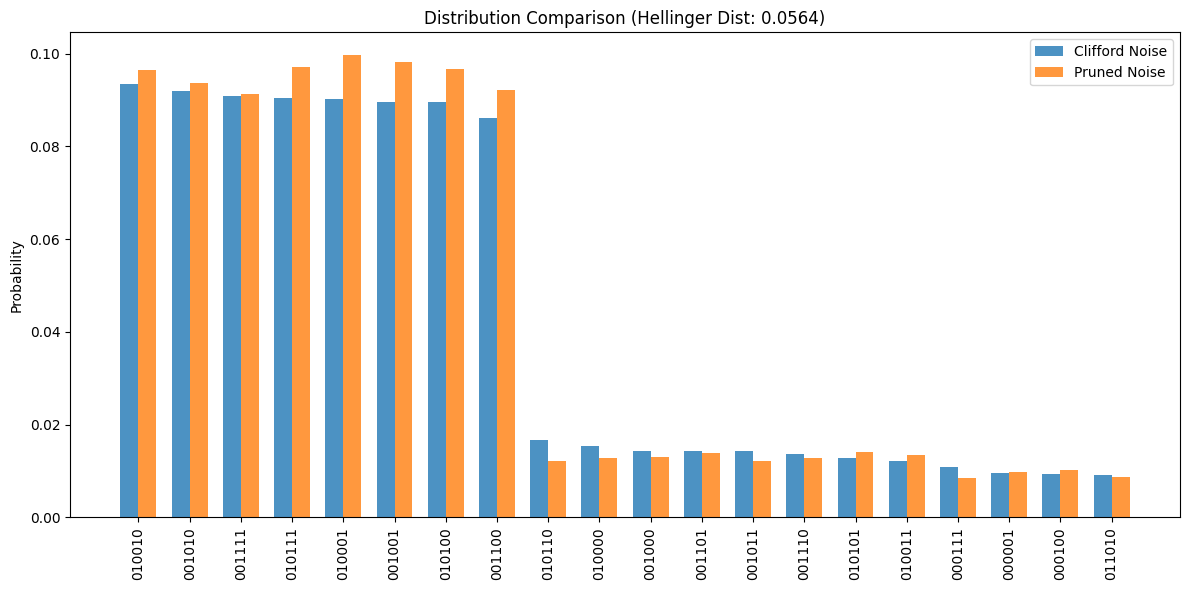

In [8]:
import matplotlib.pyplot as plt
from pipeline.utils import compute_hellinger_distance

stabilizer_pm = generate_preset_pass_manager(3, AerSimulator(method='stabilizer'))
isa_qc = stabilizer_pm.run(clifford_tqc)

pruned_noise = build_pruned_noise_model(reference_backend, tqc, only_used_gates=False)

# 1. Run Sampler with Clifford Noise (Reference)
logger.info("Running Sampler with Clifford Noise...")
sampler_clifford = Sampler(options=dict(backend_options=dict(method='stabilizer', noise_model=clifford_noise)))
job_clifford = sampler_clifford.run([isa_qc], shots=num_sampler_shots)
result_clifford = job_clifford.result()[0]
counts_clifford = result_clifford.data.classic_register.get_counts()

# Normalize to probabilities
total_clifford = sum(counts_clifford.values())
prob_clifford = {k: v / total_clifford for k, v in counts_clifford.items()}

# 2. Run Sampler with Pruned Noise
logger.info("Running Sampler with Pruned Noise...")
sampler_pruned = Sampler(options=dict(backend_options=dict(method='stabilizer', noise_model=pruned_noise)))
job_pruned = sampler_pruned.run([isa_qc], shots=num_sampler_shots)
result_pruned = job_pruned.result()[0]
counts_pruned = result_pruned.data.classic_register.get_counts()

# Normalize to probabilities
total_pruned = sum(counts_pruned.values())
prob_pruned = {k: v / total_pruned for k, v in counts_pruned.items()}

# 3. Compute Hellinger Distance
h_dist = compute_hellinger_distance(prob_clifford, prob_pruned)
print(f"\n{'='*40}")
print(f"Hellinger Distance: {h_dist:.4f}")
print(f"(0.0 = identical, 1.0 = completely different)")
print(f"{'='*40}\n")

# 4. Plot Comparison (Top 20 bitstrings)
all_keys = set(prob_clifford.keys()) | set(prob_pruned.keys())
# Sort by probability in Clifford distribution to find the most relevant ones
sorted_keys = sorted(all_keys, key=lambda k: prob_clifford.get(k, 0), reverse=True)[:20]

vals_clifford = [prob_clifford.get(k, 0) for k in sorted_keys]
vals_pruned = [prob_pruned.get(k, 0) for k in sorted_keys]

x = np.arange(len(sorted_keys))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, vals_clifford, width, label='Clifford Noise', alpha=0.8)
rects2 = ax.bar(x + width/2, vals_pruned, width, label='Pruned Noise', alpha=0.8)

ax.set_ylabel('Probability')
ax.set_title(f'Distribution Comparison (Hellinger Dist: {h_dist:.4f})')
ax.set_xticks(x)
ax.set_xticklabels(sorted_keys, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [10]:
jsd = compute_js_divergence(prob_clifford, prob_pruned)
print(f"Jensen-Shannon Divergence: {jsd:.4f}")

Jensen-Shannon Divergence: 0.0031


[2025-12-15 19:27:36,073] INFO: Sampling with 10000 shots
Sampling Time: 13.5236s
[2025-12-15 19:27:49,590] INFO: Sampling with Pruned Noise...
Pruned Sampling Time: 0.5373s

Hellinger Distance: 0.0537
Jensen-Shannon Divergence: 0.0029
(0.0 = identical, 1.0 = completely different)



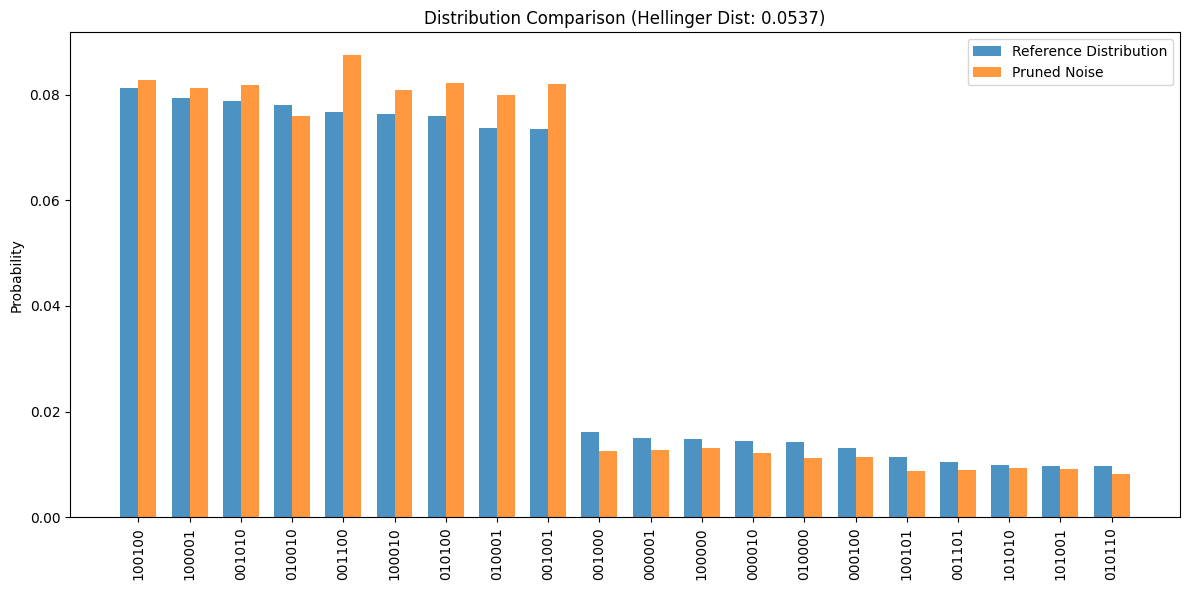

In [14]:
pruned_noise = build_pruned_noise_model(reference_backend, tqc, only_used_gates=False)

rng = np.random.default_rng(seed)
dummy_params = rng.choice([0, np.pi / 2, np.pi, 3 * np.pi / 2], size=tqc.num_parameters)
bound_tqc = tqc.assign_parameters(dummy_params)

logger.info(f"Sampling with {num_sampler_shots} shots")
tic = time.perf_counter()
final_distribution_bin = sample_circuit(bound_tqc, reference_backend, SamplerV2, num_sampler_shots)
circuit_sampling_time = time.perf_counter() - tic
print(f"Sampling Time: {circuit_sampling_time:.4f}s")

# Run Sampler with Pruned Noise
logger.info("Sampling with Pruned Noise...")
pruned_backend = AerSimulator.from_backend(
    reference_backend, 
    method='automatic', 
    noise_model=pruned_noise
)
tic = time.perf_counter()
pruned_final_distribution_bin = sample_circuit(bound_tqc, pruned_backend, SamplerV2, num_sampler_shots)
pruned_circuit_sampling_time = time.perf_counter() - tic
print(f"Pruned Sampling Time: {pruned_circuit_sampling_time:.4f}s")

# Distributions comparison metrics
h_dist = compute_hellinger_distance(final_distribution_bin, pruned_final_distribution_bin)
jsd = compute_js_divergence(final_distribution_bin, pruned_final_distribution_bin)
print(f"\n{'='*40}")
print(f"Hellinger Distance: {h_dist:.4f}")
print(f"Jensen-Shannon Divergence: {jsd:.4f}")
print(f"(0.0 = identical, 1.0 = completely different)")
print(f"{'='*40}\n")

# Plot Comparison (Top 20 bitstrings)
all_keys = set(final_distribution_bin.keys()) | set(pruned_final_distribution_bin.keys())
sorted_keys = sorted(all_keys, key=lambda k: final_distribution_bin.get(k, 0), reverse=True)[:20]

vals_reference = [final_distribution_bin.get(k, 0) for k in sorted_keys]
vals_pruned = [pruned_final_distribution_bin.get(k, 0) for k in sorted_keys]

x = np.arange(len(sorted_keys))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, vals_reference, width, label='Reference Distribution', alpha=0.8)
rects2 = ax.bar(x + width/2, vals_pruned, width, label='Pruned Noise', alpha=0.8)

ax.set_ylabel('Probability')
ax.set_title(f'Distribution Comparison (Hellinger Dist: {h_dist:.4f})')
ax.set_xticks(x)
ax.set_xticklabels(sorted_keys, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

## Tensor Network